In [1]:
import numpy as np
import pandas as pd
import cv2
import gc

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline
np.random.seed(1)

import tensorflow.keras.utils
from tensorflow.keras import utils as np_utils

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

In [2]:
full_labels = pd.read_csv('image_labels.csv')

In [3]:
full_labels.head()

filename  label
0    0.jpg      1
1    1.jpg      1
2    2.jpg      1
3    3.jpg      1
4    4.jpg      1

In [4]:
class_grouped = full_labels.groupby('label')
CLASSES = len(class_grouped)
print(CLASSES)

108


In [5]:
full_labels_value = full_labels.values

In [6]:
X_array = full_labels_value[:,0]
y_array = full_labels_value[:,1]

for index, value in enumerate(y_array):
    y_array[index] = value-1

In [7]:
y = np_utils.to_categorical(y_array, CLASSES)

In [8]:
X_array = X_array.reshape((X_array.shape[0],1))

In [9]:
full_labels_list = np.concatenate((X_array,y),axis=1).tolist()

In [10]:
nrows = 750
ncolumns = 150
channels = 3 
IMAGE_DIRECTORY = "..\\normalization\\"

def read_and_process_image(list_of_images):
    """
    Returns two arrays: 
        X is an array of resized images
        y is an array of labels
    """
    
    X = [] # images
    y = [] # labels
    
    for value in list_of_images:
        image = value[0]
        label = value[1:]
        X.append(cv2.resize(cv2.imread(IMAGE_DIRECTORY+image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))
        y.append(label)
    
    return X, y

In [11]:
X, y = read_and_process_image(full_labels_list)

In [12]:
plt.figure(figsize=(20,10))
columns = 5
for i in range(columns):
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.imshow(X[i])

In [13]:
del full_labels_list
gc.collect()

8692

In [14]:
#Convert list to numpy array
X = np.array(X)
y = np.array(y)

In [15]:
print(X.shape)

(756, 150, 750, 3)


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=2)

In [17]:
del X
del y
gc.collect()

30

In [18]:
print(X_train[0].shape)

(150, 750, 3)


In [19]:
#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)

#We will use a batch size of 32. Note: batch size should be a factor of 2.***4,8,16,32,64...***
batch_size = 4

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

In [21]:
train_generator = train_datagen.flow(X_train, y_train,batch_size=batch_size)
val_generator = validation_datagen.flow(X_val, y_val, batch_size=batch_size)

In [20]:
# setup model
conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(ncolumns,nrows,3))

Instructions for updating:
Colocations handled automatically by placer.


In [21]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 750, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 374, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 74, 374, 32)  96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 374, 32)  0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

In [22]:
# model = models.Sequential()
# model.add(conv_base)
# model.add(Flatten())
# model.add(Dense(128))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(CLASSES))
# model.add(Activation('softmax'))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(CLASSES, activation='softmax'))

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 22, 2048)       21802784  
_________________________________________________________________
flatten (Flatten)            (None, 135168)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               34603264  
_________________________________________________________________
dense_1 (Dense)              (None, 108)               27756     
Total params: 56,433,804
Trainable params: 56,399,372
Non-trainable params: 34,432
_________________________________________________________________


In [24]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

Number of trainable weights before freezing the conv base: 192
Number of trainable weights after freezing the conv base: 4


In [25]:
model.compile(optimizer='adadelta',loss='categorical_crossentropy',metrics=['accuracy'])

In [26]:
# history = model.fit_generator(train_generator, epochs=20, steps_per_epoch=ntrain,validation_data=val_generator,validation_steps=nval)
history = model.fit(x=X_train, y=y_train, steps_per_epoch=ntrain, epochs=20, validation_data=(X_val, y_val), validation_steps=nval)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20


ResourceExhaustedError: OOM when allocating tensor with shape[642,32,74,374] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node inception_v3/conv2d/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss/mul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [25]:
model.save_weights('model2_wieghts.h5')
model.save('model2_keras.h5')

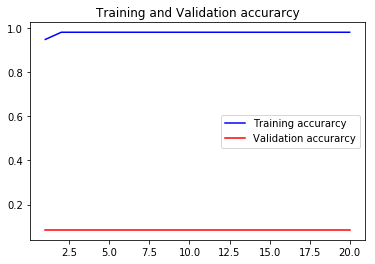

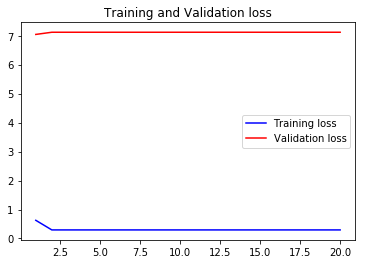

In [25]:
import matplotlib.pyplot as plt

#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()